---
#Copy of L177 - Examine Feature Maps

(code below is from `DUDL_CNN_GaussClassFeatureMaps.ipynb`)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# import MNIST digits (partial) dataset
data = np.loadtxt(open('mnist_10k.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0].astype(np.int64) # convert to int64 ('long') for PyTorch
data   = data[:,1:]

# normalize to range of [0 1]
dataNorm = data / np.max(data)

#reshape to 2D greyscale images
images = dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [3]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Convert numpy arrays to PyTorch tensors
train_data = torch.from_numpy(train_data)
test_data = torch.from_numpy(test_data)
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

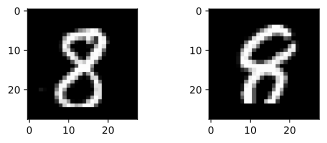

In [5]:
# sanity check - display a couple of images
tmp1 = test_loader.dataset.tensors[0][0,:]
tmp2 = test_loader.dataset.tensors[0][1,:]

fig,ax = plt.subplots(1,2,figsize=(6,2))
ax[0].imshow(torch.squeeze(tmp1), cmap='gray')
ax[1].imshow(torch.squeeze(tmp2), cmap='gray')

plt.show()

In [6]:
#global variables
chanConv1 = 3 # number of output channels for first convolutional layer
chanConv2 = 3 # number of output channels for second convolutional layer

In [7]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1,chanConv1,3,padding=1, stride=1)
      
      self.conv2 = nn.Conv2d(chanConv1,chanConv2,3,padding=1, stride=1)
      
      # fc1
      self.fc1 = nn.Linear(chanConv2*7*7,100) # 32 is the number of FLATTENED input features from the final conv layer eg: 8ch x (2x2)

      # fc2 (output)
      self.fc2 = nn.Linear(100,10)

    def forward(self,x):
      # first conv-pool set
      x = self.conv1(x)
      conv1act = F.leaky_relu(x) # grab variable so we can return this as well as net results
      x = F.avg_pool2d(conv1act,(2,2))

      # second conv-pool set
      x = self.conv2(x)
      conv2act = F.leaky_relu(x) # grab variable so we can return this as well as net results
      x = F.max_pool2d(conv2act,(2,2))

      # FCN part
      x = x.reshape(x.shape[0],-1) # flatten
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)
      return x,conv1act,conv2act #returns results AND Feature Maps

  # create the model instance
  net = gausnet()

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [8]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
X = X.float()  # Convert X to float
yHat,featmap1,featmap2 = net(X) # get the feature maps as well as yHat predictions
# if this line fails, you likely have a size mismatch : RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x144 and 1024x100). alter the 144 to match the number of features from the final conv layer
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 10])

Feature map after conv1
torch.Size([32, 3, 28, 28])

Feature map after conv2
torch.Size([32, 3, 14, 14])


In [9]:
# count the total number of parameters in the model - pass a single input image through the model       
summary(net)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            30
├─Conv2d: 1-2                            84
├─Linear: 1-3                            14,800
├─Linear: 1-4                            1,010
Total params: 15,924
Trainable params: 15,924
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            30
├─Conv2d: 1-2                            84
├─Linear: 1-3                            14,800
├─Linear: 1-4                            1,010
Total params: 15,924
Trainable params: 15,924
Non-trainable params: 0

torch.Size([3, 1, 3, 3])

k1: max= tensor(0.1742)   min= tensor(-0.2060)     tensor([[ 0.1742, -0.0296,  0.1644],
        [-0.0248, -0.0731,  0.0790],
        [-0.2060, -0.0878,  0.0641]])

k2: max= tensor(0.2550)   min= tensor(-0.2024)     tensor([[ 0.0049,  0.0978,  0.2550],
        [-0.2024,  0.2317,  0.2242],
        [ 0.2342, -0.1412,  0.0470]])


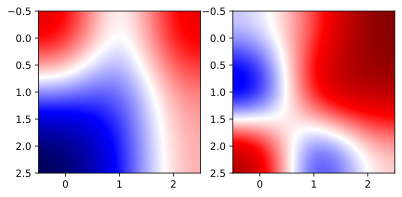

In [10]:
# view first convolution layer kernels. note these will be random noise since the model has not been trained
# re-run this cell after training to see the learned kernels

layer = list(net.modules())[1] # get the first layer (conv1)
kernel = layer.weight.data
print(kernel.shape)
k1=kernel[0,0,:,:]
k2=kernel[1,0,:,:]
rangemax = max(k1.max(),k2.max())
rangemin = min(k1.min(),k2.min())

print('\nk1: max=',k1.max(),'  min=',k1.min(),'   ',k1)
print('\nk2: max=',k2.max(),'  min=',k2.min(),'   ',k2)

# plot the 2 kernels
fig,ax = plt.subplots(1,2)
ax[0].imshow(kernel[0,0,:,:],cmap='seismic',vmin=rangemin,vmax=rangemax,interpolation='bicubic')
ax[1].imshow(kernel[1,0,:,:],cmap='seismic',vmin=rangemin,vmax=rangemax,interpolation='bicubic')


In [11]:
def function2trainTheModel():
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      X = X.float()  # Convert X to float
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( (torch.argmax(yHat, dim=1) == y).float().mean().item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # calc TEST accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():         # deactivate autograd
      X = X.float()               # Convert X to float
      yHat = net(X)[0]            # we only need the first output, no labels
      loss = lossfun(yHat,y)

    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean((torch.argmax(yHat, dim=1) == y).float()).item()
    print ('epoch:',epochi, ' Test Accuracy:',round(testAcc[epochi].item(),2),'%')
  return trainLoss,testLoss,trainAcc,testAcc,net

TRAIN model, show results

In [12]:
trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel()


epoch: 0  Test Accuracy: 86.3 %
epoch: 1  Test Accuracy: 89.8 %
epoch: 2  Test Accuracy: 90.3 %
epoch: 3  Test Accuracy: 92.3 %
epoch: 4  Test Accuracy: 91.9 %
epoch: 5  Test Accuracy: 92.1 %
epoch: 6  Test Accuracy: 93.5 %
epoch: 7  Test Accuracy: 94.6 %
epoch: 8  Test Accuracy: 94.9 %
epoch: 9  Test Accuracy: 95.2 %
epoch: 10  Test Accuracy: 95.6 %
epoch: 11  Test Accuracy: 96.3 %
epoch: 12  Test Accuracy: 96.7 %
epoch: 13  Test Accuracy: 96.0 %
epoch: 14  Test Accuracy: 96.5 %
epoch: 15  Test Accuracy: 96.8 %
epoch: 16  Test Accuracy: 96.6 %
epoch: 17  Test Accuracy: 95.7 %
epoch: 18  Test Accuracy: 96.4 %
epoch: 19  Test Accuracy: 96.2 %
epoch: 20  Test Accuracy: 96.9 %
epoch: 21  Test Accuracy: 96.6 %
epoch: 22  Test Accuracy: 95.8 %
epoch: 23  Test Accuracy: 97.1 %
epoch: 24  Test Accuracy: 96.8 %
epoch: 25  Test Accuracy: 96.4 %
epoch: 26  Test Accuracy: 97.1 %
epoch: 27  Test Accuracy: 96.9 %
epoch: 28  Test Accuracy: 96.9 %
epoch: 29  Test Accuracy: 96.8 %
epoch: 30  Test Accu

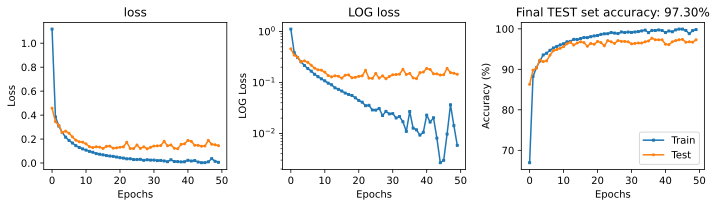

In [13]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

ax[0].plot(trainLoss,'s-',label='Train',markersize=2)
ax[0].plot(testLoss,'o-',label='Test',markersize=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('loss')

ax[1].plot(trainLoss,'s-',label='Train',markersize=2)
ax[1].plot(testLoss,'o-',label='Test',markersize=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('LOG Loss')
ax[1].set_title('LOG loss')
ax[1].set_yscale('log')

ax[2].plot(trainAcc,'s-',label='Train',markersize=2)
ax[2].plot(testAcc,'o-',label='Test',markersize=2)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title(f'Final TEST set accuracy: {testAcc[-1]:.2f}%')
ax[2].legend()
plt.tight_layout()
plt.show()

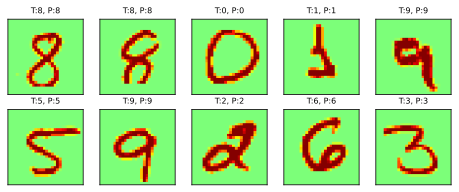

In [14]:
# visualize some images
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X.float())

fig,axs = plt.subplots(2,5,figsize=(8,3))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , torch.argmax(yHat[i]).item() )
  #set small font size
  ax.set_title('T:%s, P:%s'%t,fontsize=8)
  
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Draw the feature maps

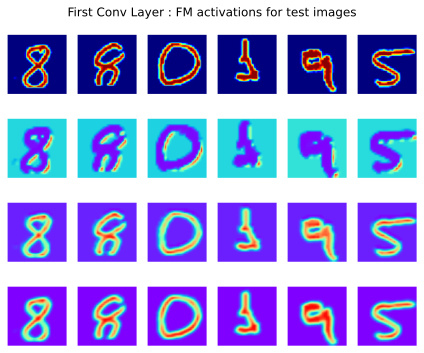

In [15]:
# Feature maps from the conv1 layer
fig,axs = plt.subplots(chanConv1+1,6,figsize=(6,5))
for pici in range(6):
  img = X[pici,0,:,:].detach()                      # the original picture
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(chanConv1):
    # extract feature maps for this image
    img = featmap1[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='rainbow',interpolation='bilinear')
    axs[feati+1,pici].axis('off')

plt.tight_layout()
plt.suptitle('First Conv Layer : FM activations for test images',x=.5,y=1.01)
plt.show()

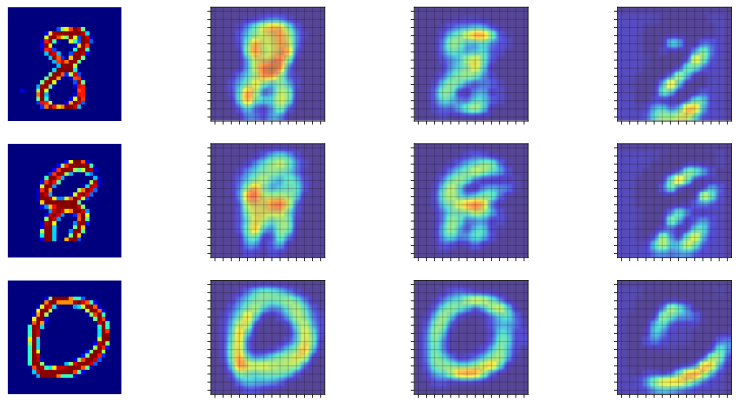

In [16]:
# Repeat for feature2 maps
fig,axs = plt.subplots(3,chanConv2+1,figsize=(14,7))
for pici in range(3):
  img = X[pici,0,:,:].detach() # show original picture
  axs[pici,0].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[pici,0].axis('off')
  for feati in range(chanConv2):

    # extract the feature map from this image
    img = featmap2[pici,feati,:,:].detach()
    axs[pici,feati+1].imshow(img,cmap='jet',vmin=0,vmax=torch.max(img)*.9,interpolation='bicubic',alpha=.8)
    axs[pici,feati+1].imshow(img,cmap='viridis',vmin=0,vmax=torch.max(img)*.9,interpolation='nearest',alpha=.5)
    
    # set x and y ticks
    axs[pici,feati+1].set_xticks(np.arange(0, img.shape[1], 1))  # replace final no. with desired x-spacing
    axs[pici,feati+1].set_yticks(np.arange(0, img.shape[0], 1))  # replace with desired y-spacing
    
    # remove x and y tick labels
    axs[pici,feati+1].set_xticklabels([])
    axs[pici,feati+1].set_yticklabels([])
    
    # plot grid
    axs[pici,feati+1].grid(True, which='both', color='k', linewidth=1, linestyle='-', alpha=.2)

plt.show()

# Spatial correlations across the feature maps

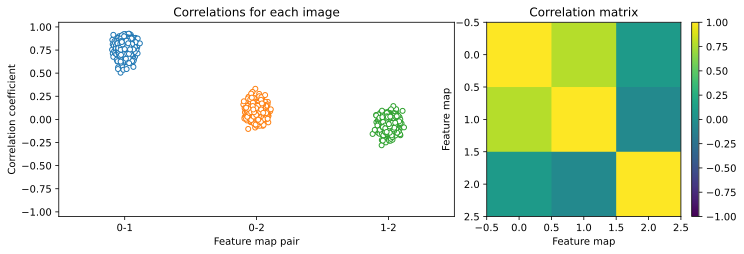

In [17]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))


# now visualize the correlations
fig = plt.figure(figsize=(10,3))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=5)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

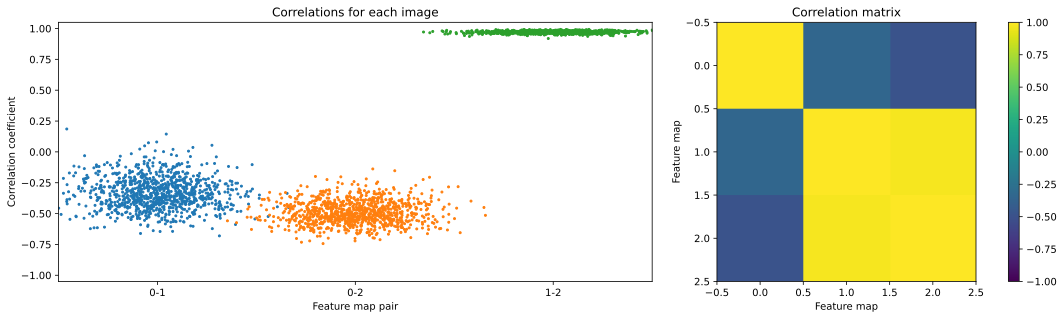

In [18]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]

# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))

# visualize FM-pair correlations
fig = plt.figure(figsize=(15,4))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/5,allrs[:,i],'o',markersize=2)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
fig.colorbar(h,cax=cax)
plt.show()

Additional explorations

* The code grabs the Feature Maps *after* relu. Modify to get *pre-relu* activations, which corresponds to the linear part of the activations. (may need to modify color range?). Are they different before vs after relu? Which maps are more relevant to interpret when trying to understand how the CNN works and how it represents data?

* Relatedly, look at activations after pooling layers? Which is better and what are the advantages of inspecting the pre- vs. post-pooled activation maps?
